## Train ResNets

### created by Yuying Liu, 04/30/2020

This script is a template for training neural network time-steppers for different systems and different time scales. To reproduce the results in the paper, one needs to obtain all 11 neural network models for each nonlinear system under study. For setup details, please refer to Table 2 in the paper.

In [1]:
import os
import sys
import torch
import numpy as np

import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables

k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 0.01# 0.0005                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 128, 128, 128, 2]  # architecture of the neural network

In [3]:
# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

In [4]:
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
print(train_data.shape)
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

print(train_data[0,:,:])

# create dataset object
dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

(1600, 5121, 2)
[[0.94931828 0.80092426]
 [0.94884374 0.80191758]
 [0.94836943 0.80289206]
 ...
 [0.07346023 0.00600329]
 [0.07342351 0.00599722]
 [0.0733868  0.00599116]]


C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


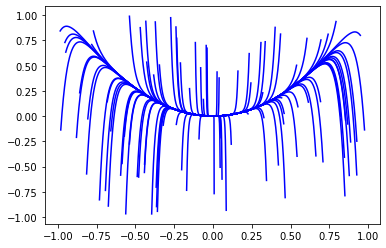

In [5]:
for i in range(100):
    plt.plot(train_data[i,:,0], train_data[i,:,1], 'b')

In [6]:
for k in [0, 1, 2, 3, 4, 5]:
    print("k = ", k)
    step_size = 2**k
    dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
    print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = torch.load(os.path.join(model_dir, model_name), map_location=device)
        model.device = device
    except:
        print('create model {} ...'.format(model_name))
        model = net.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_dir, model_name))

k =  0
torch.Size([1600, 2])
epoch 1000, training loss 3.3269607069286167e-09, validation loss 4.830931210619838e-09
(--> new model saved @ epoch 1000)
--> model has reached an accuracy of 1e-8! Finished training!
--> new model saved @ epoch 1001
k =  1
torch.Size([1600, 2])
epoch 1000, training loss 5.858217910770236e-09, validation loss 7.770939447482306e-09
(--> new model saved @ epoch 1000)
--> model has reached an accuracy of 1e-8! Finished training!
k =  2
torch.Size([1600, 2])
epoch 1000, training loss 3.903003698013663e-09, validation loss 9.12036757227952e-09
(--> new model saved @ epoch 1000)
--> model has reached an accuracy of 1e-8! Finished training!
k =  3
torch.Size([1600, 2])
epoch 1000, training loss 8.63835847297878e-09, validation loss 1.9606211765221815e-08
(--> new model saved @ epoch 1000)
epoch 2000, training loss 1.3758502781513471e-08, validation loss 2.4555514954727187e-08
epoch 3000, training loss 5.3964726021149545e-08, validation loss 5.7460784574914214e-08

epoch 85000, training loss 2.2693251366945333e-07, validation loss 1.9064547984726232e-07
epoch 86000, training loss 1.1344666539514492e-08, validation loss 2.0690386293154006e-08
epoch 87000, training loss 2.6437254163624857e-08, validation loss 3.592232289406638e-08
epoch 88000, training loss 1.4893034006036032e-07, validation loss 1.5671511732762156e-07
epoch 89000, training loss 1.0736032862723732e-07, validation loss 1.0792495430678173e-07
epoch 90000, training loss 7.890738729088298e-09, validation loss 1.7672794783152312e-08
(--> new model saved @ epoch 90000)
epoch 91000, training loss 2.7657366175048992e-08, validation loss 3.961929806450826e-08
epoch 92000, training loss 2.087869255262831e-08, validation loss 2.998140047338893e-08
epoch 93000, training loss 7.944339586174465e-08, validation loss 8.052513322809318e-08
epoch 94000, training loss 4.762177852057903e-08, validation loss 5.002938507914223e-08
epoch 95000, training loss 5.069923503242535e-08, validation loss 6.34190

epoch 74000, training loss 3.9576125487883473e-08, validation loss 5.0020481978663156e-08
epoch 75000, training loss 1.2197912724332127e-07, validation loss 1.3622508276966983e-07
epoch 76000, training loss 5.974069949843397e-07, validation loss 6.613900609409029e-07
epoch 77000, training loss 7.400148405167783e-08, validation loss 8.464014911169215e-08
epoch 78000, training loss 2.739400173368267e-08, validation loss 3.4955071726017195e-08
epoch 79000, training loss 8.720299149445054e-08, validation loss 1.01142852315661e-07
epoch 80000, training loss 2.090599160453621e-08, validation loss 3.087569311333027e-08
epoch 81000, training loss 5.77569721826876e-07, validation loss 6.595313379875734e-07
epoch 82000, training loss 3.225323723654583e-07, validation loss 3.3671338428575837e-07
epoch 83000, training loss 1.4511850565668283e-07, validation loss 1.684565376081082e-07
epoch 84000, training loss 2.0568636571738352e-08, validation loss 3.017069971633646e-08
epoch 85000, training loss

epoch 65000, training loss 5.534504410320551e-08, validation loss 7.203899343721787e-08
epoch 66000, training loss 5.7254400331885336e-08, validation loss 7.541652280451672e-08
epoch 67000, training loss 2.370543370489031e-07, validation loss 2.6912704242931795e-07
epoch 68000, training loss 8.756313718549791e-08, validation loss 1.0865883837141155e-07
epoch 69000, training loss 6.925632334287002e-08, validation loss 8.929312400596245e-08
epoch 70000, training loss 2.813974901982874e-07, validation loss 2.6315115064790007e-07
epoch 71000, training loss 6.51002238782894e-08, validation loss 8.270362883422422e-08
epoch 72000, training loss 3.7236324601508386e-07, validation loss 3.8018706050024775e-07
epoch 73000, training loss 1.0596448163369132e-07, validation loss 1.3337617588149442e-07
epoch 74000, training loss 3.2030592933551816e-07, validation loss 3.309194198664045e-07
epoch 75000, training loss 2.5297094907728024e-06, validation loss 2.689961320356815e-06
epoch 76000, training l

In [7]:
 

.

SyntaxError: invalid syntax (<ipython-input-7-a5d5b61aa8a6>, line 1)